# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Anomalies Detection using Autoencoders

## Notebook 5: Compare Autoencoder with Classifier

## Yuri Balasanov, Andrey Kobyshev, &copy; iLykei 2018

This notebook compares anomalies detection by autoencoder and by classifier trained on one type of attack. Then both are tried on a different type of attack.

# Motivation

The main goal of this notebook is to show that autoencoder is a more universal method for anomaly detection than classifier because autoencoder is trained on data without anomalies, thus it can detect rare deviations from normal regardless of their type.

Unlike classifier autoencoder solution does not require labels for training, some limited number of labels may be useful only for validation. This means that autoencoder solution does not get affected by imbalanced classes, which is a typical challenge for classification of anomalies as rare events.

For comparison this notebook shows how to build a classifier - a neural network that is trained with labels to distinguish normal and anomaly classes (attack of type "ipsweep").

Dataset is the same as in <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb" target="_blank">MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb</a> 

After training and testing classifier on one type of attack the same classifier will be checked on a different type of attack. For both classes of attack classifier will need to be compared with the autoencoder solution. Complete this comparison when autoencoder model is trained and saved to file.

Import the needed libraries.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model, load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from sklearn import preprocessing
import seaborn as sns
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support,
                             cohen_kappa_score, accuracy_score)
import sklearn.metrics as skm
from pylab import rcParams
import pickle

# Set some visualization parameters:
rcParams['figure.figsize'] = 14, 8
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

Using TensorFlow backend.


In [2]:
rcParams['figure.figsize'] = 14, 8
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# Data

Read train dataset `kddCupTrain.csv` from `kddCupData.zip`:

In [3]:
kddCupTrain = pd.read_csv('kddCupTrain.csv', header=None)

and prepare the data as described in <a href="https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb" target="_blank">MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb</a>, **except: do not separate the "normal" instances from the training dataset. A model will be fit to the entire dataset**.  

Note that the features list should be exactly the same as it was for an Autoencoder.

In [4]:
#Skiped code
#Prepare the training data


After all transformations and preparations the dataset should have format as follows:

`print(kddCupTrain.head(2))`  

`'       0         4         5        6         8         9        10  \
0 -0.16002 -0.011000 -0.081782 -0.00281 -0.002293 -0.052638 -0.007482   
1 -0.16002 -0.012928 -0.092466 -0.00281 -0.002293 -0.052638 -0.007482   `

`'       11        12        13        14        15        16        17  \
0  0.638870 -0.004254 -0.017549 -0.010038 -0.007049 -0.021138 -0.018912   
1 -1.565263 -0.004254 -0.017549 -0.010038 -0.007049 -0.021138 -0.018912   `

`'       18        20        21        22        23        24        25  \
0 -0.063614 -0.001502 -0.061903  0.165707  0.000046 -0.054189 -0.065417   
1 -0.063614 -0.001502 -0.061903 -0.399884 -0.459251 -0.054189 -0.065417   `

`'       26        27        28        29        30        31        32  \
0 -0.244655 -0.247066  0.157689 -0.156892 -0.486813 -0.285323  0.612755   
1  4.115563  4.137151  0.157689 -0.156892 -0.486813 -1.400495  0.612755   `

`'       33       34        35        36        37        38        39  \
0  0.504939 -0.31261 -0.456592 -0.249604 -0.070939  0.590035 -0.257053   
1  0.504939 -0.31261  2.893958  0.327044 -0.070939 -0.067872  4.180321   `

`'       40    1_icmp     1_tcp     1_udp     2_IRC     2_X11    2_auth  \
0 -0.255692 -0.159083  0.529347 -0.490912 -0.023004 -0.011634 -0.048641   
1  4.251843 -0.159083  0.529347 -0.490912 -0.023004 -0.011634 -0.048641   `

`'    2_ctf  2_domain  2_domain_u   2_eco_i   2_ecr_i  2_finger    2_ftp  \
0 -0.003679 -0.006882    -0.24971 -0.125649 -0.059192 -0.071618 -0.06236   
1 -0.003679 -0.006882    -0.24971 -0.125649 -0.059192 -0.071618 -0.06236   `

`' 2_ftp_data  2_gopher   2_http   2_imap4    2_link     2_mtp    2_name  \
0   -0.200526 -0.003679  0.76902 -0.001839 -0.003829 -0.003522 -0.003829   
1   -0.200526 -0.003679  0.76902 -0.001839 -0.003829 -0.003522 -0.003829   `

`'  2_ntp_u   2_other   2_pop_3  2_private   2_red_i  2_remote_job     2_rje  \
0 -0.062415 -0.246557 -0.030349  -0.286053 -0.003186     -0.003522 -0.003679   
1 -0.062415 -0.246557 -0.030349  -0.286053 -0.003186     -0.003522 -0.003679`

`'  2_shell    2_smtp     2_ssh  2_telnet  2_tftp_u  2_tim_i    2_time  \
0 -0.002375 -0.327462 -0.004749 -0.047641 -0.001839 -0.00281 -0.023248   
1 -0.002375 -0.327462 -0.004749 -0.047641 -0.001839 -0.00281 -0.023248`   

`' 2_urh_i   2_urp_i   2_whois     3_OTH     3_REJ    3_RSTO    3_RSTR  \
0 -0.01234 -0.074221 -0.003358 -0.003679 -0.241512 -0.025561 -0.018488   
1 -0.01234 -0.074221 -0.003358 -0.003679  4.140580 -0.025561 -0.018488`

`'     3_S0      3_S1      3_S2    3_S3      3_SF      3_SH  Class  
0 -0.020706 -0.022906 -0.012476 -0.0068  0.246491 -0.001062      0  
1 -0.020706 -0.022906 -0.012476 -0.0068 -4.056951 -0.001062      0`  

In [5]:
# Save the prepared data to the file:

# pickle.dump(kddCupTrain, open('./Saved_Files/prepared_kddCupTrain.sav', 'wb'))

In [6]:
# Load the prepared data from the file:

kddCupTrain = pickle.load(open('./Saved_Files/prepared_kddCupTrain.sav', 'rb'))
featuresList = [col for col in kddCupTrain if col != 'Class']

# Building Classifier

Input layer of the classifier has the same shape as the Autoencoder.  
The output layer has single unit. 

Select number and dimentions of hidden layers. The model should not be too complex. One or two hidden layers is enough.

In [7]:
input_dim = len(featuresList)
input_layer = Input(shape=(input_dim, ))
classifier = Dense(11, activation='relu')(input_layer)
classifier = Dropout(0.5)(classifier)
classifier = Dense(1, activation='sigmoid')(classifier)
classModel = Model(inputs=input_layer, outputs=classifier)
classModel.summary()

W0806 13:10:18.747451 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0806 13:10:18.759162 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0806 13:10:18.761170 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0806 13:10:18.774307 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecate

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 83)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                924       
_________________________________________________________________
dropout_1 (Dropout)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 12        
Total params: 936
Trainable params: 936
Non-trainable params: 0
_________________________________________________________________


Split the dataset into train and validation subsets:

In [8]:
train, test = train_test_split(kddCupTrain, 
                               test_size=0.2, 
                               shuffle=True, 
                               stratify=kddCupTrain['Class'],
                               random_state=1)

Fit the model using following arguments of function `fit()`:

`x = train[featuresList],
y = train['Class'],
validation_data=(test[featuresList], test['Class'])`  

Use ModelCheckpoint to save the best model to file.  

Experiment with parameters like: `epochs`, `batch_size`, `callbacks`, etc.

In [9]:
nb_epoch = 50
batch_size = 256
adam = Adam(lr=0.0005)
classModel.compile(optimizer=adam, 
                    loss='mean_squared_error')

earlystopping = EarlyStopping(monitor='val_loss', patience=1, verbose=0)
checkpointer = ModelCheckpoint(filepath="./Saved_Files/classifier.h5",
                               verbose=0,
                               save_best_only=True)

class_history = classModel.fit(x=train[featuresList], y=train['Class'],
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test[featuresList], test['Class']),
                    verbose=1,
                    callbacks=[earlystopping, checkpointer]).history

W0806 13:10:20.805336 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0806 13:10:21.256899 139809225430848 deprecation_wrapper.py:119] From /home/yuri/anaconda3/envs/newtf/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 788209 samples, validate on 197053 samples
Epoch 1/50
788209/788209 [==============================] - 6s 8us/step - loss: 0.0269 - val_loss: 9.1070e-04
Epoch 2/50
788209/788209 [==============================] - 7s 9us/step - loss: 0.0053 - val_loss: 6.4425e-04
Epoch 3/50
788209/788209 [==============================] - 7s 10us/step - loss: 0.0027 - val_loss: 5.9642e-04
Epoch 4/50
788209/788209 [==============================] - 7s 8us/step - loss: 0.0022 - val_loss: 5.8153e-04
Epoch 5/50
788209/788209 [==============================] - 7s 8us/step - loss: 0.0021 - val_loss: 5.8101e-04
Epoch 6/50
788209/788209 [==============================] - 7s 9us/step - loss: 0.0020 - val_loss: 5.6934e-04
Epoch 7/50
788209/788209 [==============================] - 7s 9us/step - loss: 0.0020 - val_loss: 5.6103e-04
Epoch 8/50
788209/788209 [==============================] - 7s 9us/step - loss: 0.0021 - val_loss: 5.4565e-04
Epoch 9/50
788209/788209 [==============================] - 7s 8us/

# Evaluating Classifier

Load the model saved by `ModelCheckpoint`: 

In [10]:
fittedClassifier = load_model('./Saved_Files/classifier.h5')

Look at the fitting history:

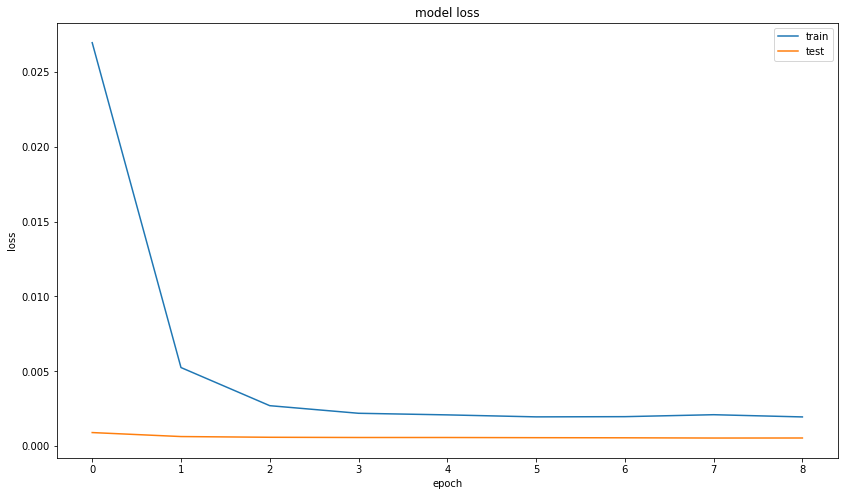

In [11]:
plt.plot(class_history['loss'])
plt.plot(class_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

Using this model make prediction for the validation dataset:  

In [12]:
testProb = fittedClassifier.predict(test[featuresList])

Interpret `testProb` as confidence in detection of attacks.  
Create a dataframe with "predicted probabilities" and "true class" columns.  

In [13]:
testProb = testProb[:,0]
class_prob_df = pd.DataFrame({'probabilities': testProb,
                        'true_class': test['Class']})

Construct the ROC curve and calculate AUC value in the same way as in [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb).

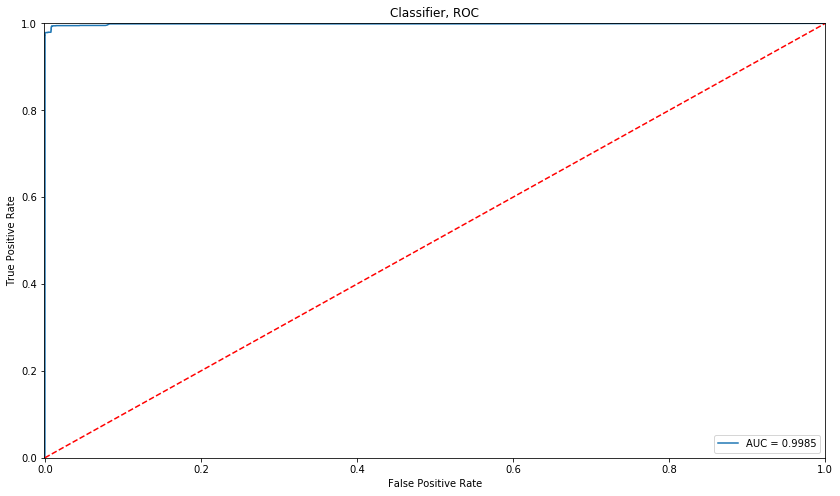

In [14]:
fpr, tpr, thresholds = roc_curve(class_prob_df.true_class, class_prob_df.probabilities)
roc_auc = auc(fpr, tpr)

plt.title('Classifier, ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

![](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fclassifier_validation_ROC.png)

Plot the predicted probabilities of normal and attack classes (see [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb) for example of graph).  

Select a threshold for predicting class from probability.

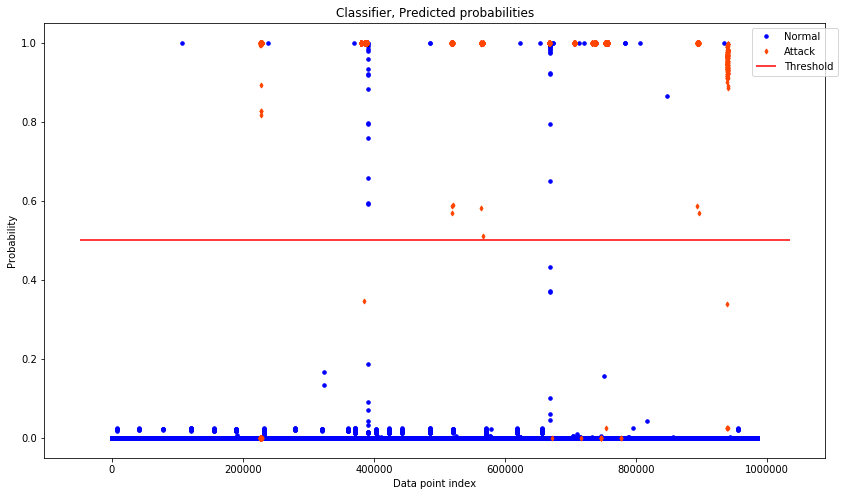

In [15]:
class_threshold = 0.5
groups = class_prob_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.probabilities, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(class_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Classifier, Predicted probabilities")
plt.ylabel("Probability")
plt.xlabel("Data point index")
plt.show();

![](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2Fclassifier_validation_prob.png)

Plot the confusion matrix for the selected threshold (see [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb) for example). 

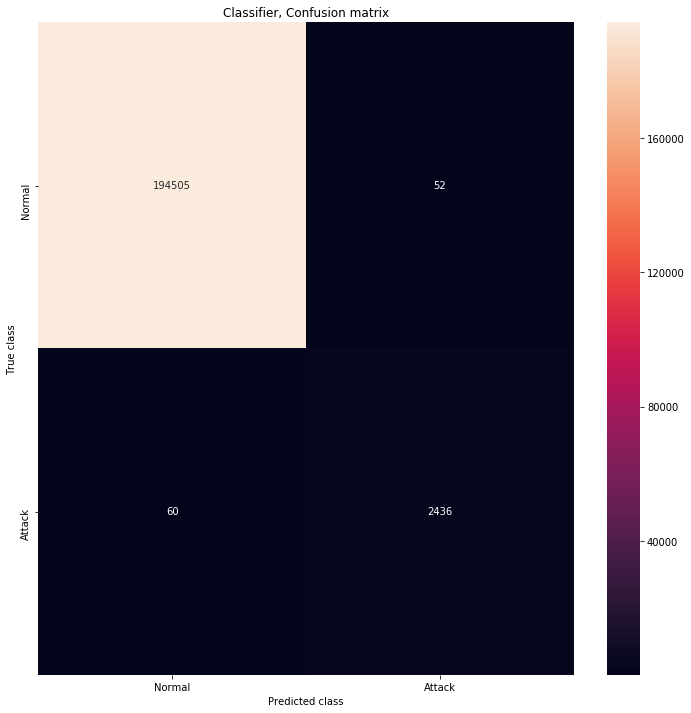

In [16]:
LABELS = ["Normal", "Attack"]
y_pred = [1 if e > class_threshold else 0 for e in class_prob_df.probabilities.values]
conf_matrix = confusion_matrix(class_prob_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Classifier, Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa (like in [FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb)).

In [17]:
print("Cohen's Kappa = ", cohen_kappa_score(class_prob_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(class_prob_df.true_class, y_pred))

Cohen's Kappa =  0.9772402631707235
Accuracy =  0.9994316249942908


This is the quality of the trained classifier for detecting attack of type "ipsweep"

# Compare the Classifier and the Autoencoder on Validation Data

Load the trained Autoencoder Model that has been saved in section 2.2. of [MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb).  

In [18]:
fittedAutoencoder = load_model('./Saved_Files/autoencoder.h5')

Reconstruct the validation dataset, calculate the mean squared error of the reconstruction ([FMScA_32017_AMLAI_AE3_FraudDetection.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE3_FraudDetection.ipynb)).  

In [19]:
aePredictions = fittedAutoencoder.predict(test[featuresList])
mse = skm.mean_squared_error(test[featuresList].transpose(),
                             aePredictions.transpose(),
                             multioutput='raw_values')
ae_error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': test['Class']})

Construct a ROC curve for the reconstruction error and the labels of the `test` dataset.  
Calculate AUC value.  

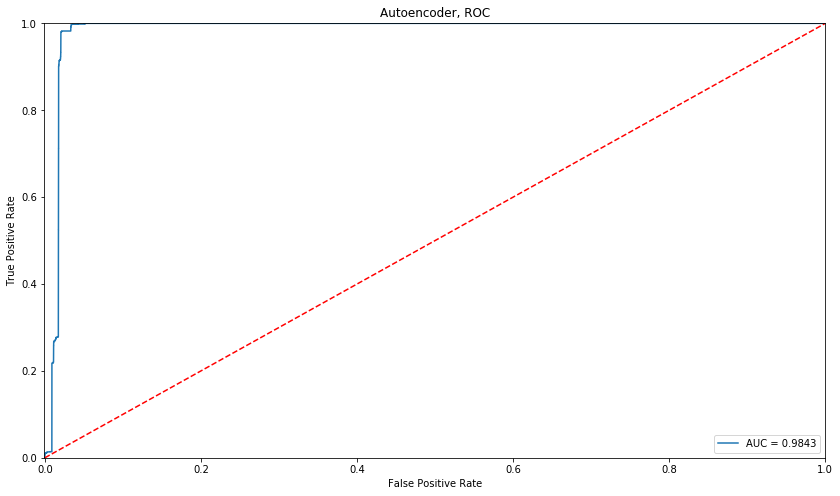

In [20]:
fpr, tpr, thresholds = roc_curve(ae_error_df.true_class, ae_error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Autoencoder, ROC')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Select a high level quantile of the MSE sample as a threshold for the attack detection.  
Plot the reconstruction error for different classes.

In [21]:
quantileLevel = 0.97
ae_threshold = ae_error_df[ae_error_df.true_class==0].reconstruction_error.quantile(q=quantileLevel)
ae_threshold

0.9805704863321156

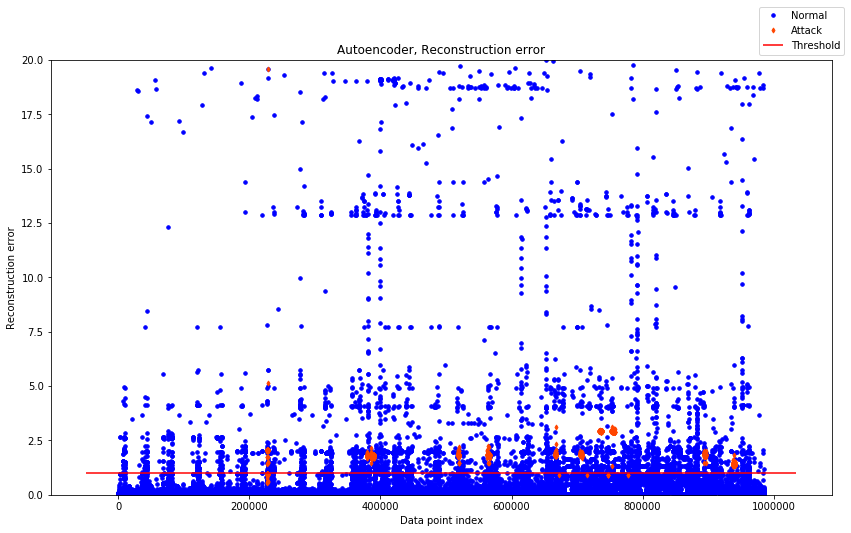

In [22]:
groups = ae_error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(ae_threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
          colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Autoencoder, Reconstruction error")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim([0,20])
plt.show();

Plot the confusion matrix for the selected threshold.  

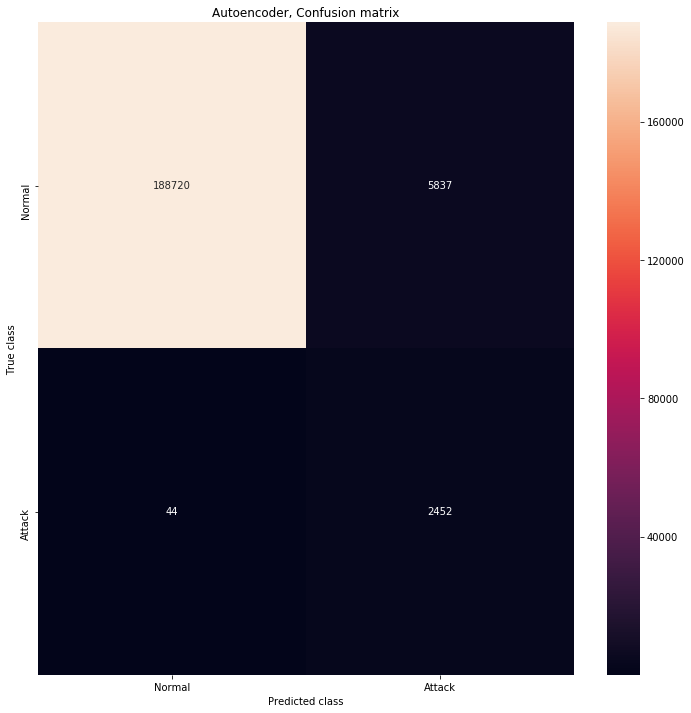

In [23]:
y_pred = [1 if e > ae_threshold else 0 for e in ae_error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(ae_error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Autoencoder, Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa:

In [24]:
print("Cohen's Kappa = ", cohen_kappa_score(ae_error_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(ae_error_df.true_class, y_pred))

Cohen's Kappa =  0.4438777202651313
Accuracy =  0.9701552374234343


Note that classifier gives better results on the validation dataset.  

Compare both methods using new test data containing another type of anomaly: "portsweep".  

# Read and Transform Test Dataset with Different Class of Attack

Read test dataset from file ['kddCup_TestForClassifier.csv'](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FkddCup_TestForClassifier.zip) and check it for missing values.

In [25]:
kddCupTest = pd.read_csv('kddCup_TestForClassifier.csv', header=None)
print("Shape of kddCupTest: ",kddCupTest.shape)
print("There are any missing values: ", kddCupTest.isnull().values.any())
print(kddCupTest.head(6))

Shape of kddCupTest:  (98279, 42)
There are any missing values:  False
     0    1        2   3    4     5   6   7   8   9   10  11  12  13  14  15  \
0     0  tcp     http  SF  452  3900   0   0   0   0   0   1   0   0   0   0   
1     0  udp  private  SF  105   145   0   0   0   0   0   0   0   0   0   0   
2     0  tcp     http  SF  310  1923   0   0   0   0   0   1   0   0   0   0   
3     0  tcp     http  SF  320  1274   0   0   0   0   0   1   0   0   0   0   
4  2615  udp    other  SF  145   105   0   0   0   0   0   0   0   0   0   0   
5     0  tcp     http  SF  344  9356   0   0   0   0   0   1   0   0   0   0   

   16  17  18  19  20  21  22  23   24   25   26   27   28   29    30   31  \
0   0   0   0   0   0   0  33  33  0.0  0.0  0.0  0.0  1.0  0.0  0.00  255   
1   0   0   0   0   0   0   1   1  0.0  0.0  0.0  0.0  1.0  0.0  0.00  255   
2   0   0   0   0   0   0   5  20  0.0  0.0  0.0  0.0  1.0  0.0  0.10   14   
3   0   0   0   0   0   0  37  58  0.0  0.0  0.0  0.0  1

`kddCupTest` contains labels, so it is possible to compare quality of predictions by different models.  

The label column (**"41"**) contains 0 for "normal" connections and 1 for attacks.  
Rename column **"41"** to **"Class"**.  

In [26]:
kddCupTest.rename(columns={41:'Class'}, inplace=True)

Transform the test data like in [MScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb](https://ilykei.com/api/fileProxy/documents%2FAdvanced%20Machine%20Learning%2FAnomalies%20Detection%2FMScA_32017_AMLAI_AE4_kddCup_Instructions.ipynb).

Note that this time there is label column in the test dataset.  

In [27]:
# Skipped code


After all transformations `kddCupTest` should have exactly same columns list as `kddCupTrain`.

In [28]:
# Load the prepared data from the file:

kddCupTest = pickle.load(open('./Saved_Files/prepared_kddCupTest.sav', 'rb'))

## Predict Using Classifier and Autoencoder

Make predictions for `kddCupTest` using `fittedClassifier` and `fittedAutoencoder`.

Calculate AUC for both models and construct plots of AUC. errors and confusion table as was done for the validation dataset. 

Use same thresholds as selected for the validation data. 
Calculate Accuracy and Cohen's Kappa for both models.  

Make prediction using fittedClassifier

In [29]:
testProb = fittedClassifier.predict(kddCupTest[featuresList])
testProb = testProb[:,0]
new_class_prob_df = pd.DataFrame({'probabilities': testProb,
                        'true_class': kddCupTest['Class']})

Construct the ROC curve and calculate AUC for the classifier

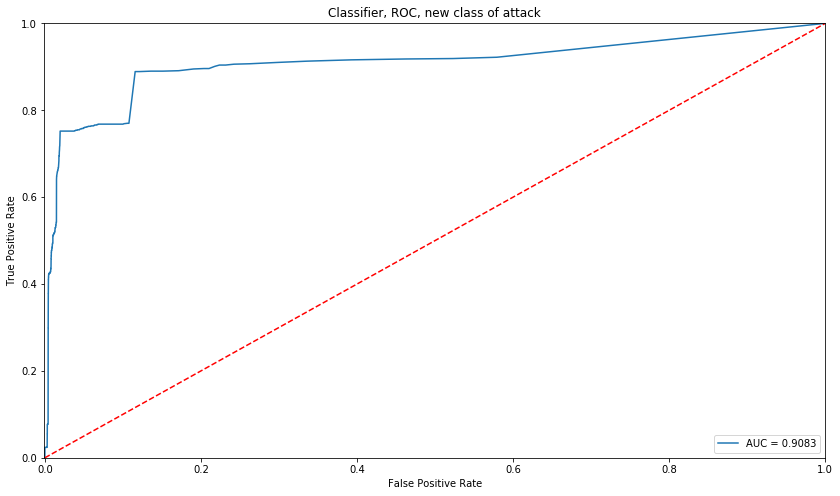

In [30]:
fpr, tpr, thresholds = roc_curve(new_class_prob_df.true_class, new_class_prob_df.probabilities)
roc_auc = auc(fpr, tpr)

plt.title('Classifier, ROC, new class of attack')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Plot the predicted probabilities of classes.

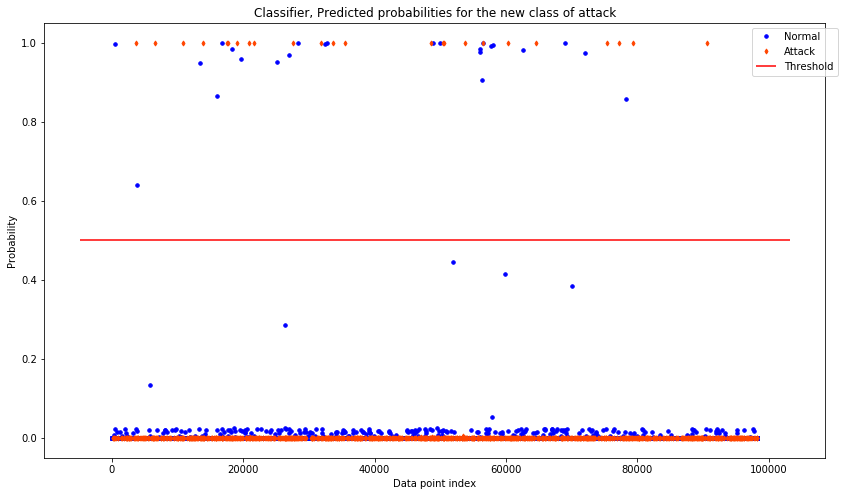

In [31]:
groups = new_class_prob_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.probabilities, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(class_threshold, ax.get_xlim()[0], ax.get_xlim()[1], 
          colors="r", zorder=100, label='Threshold')
#ax.set_ybound(lower=0,upper=0.0003)
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Classifier, Predicted probabilities for the new class of attack")
plt.ylabel("Probability")
plt.xlabel("Data point index")
plt.show();

Plot confusion matrix for the threshold selected for the training dataset.  

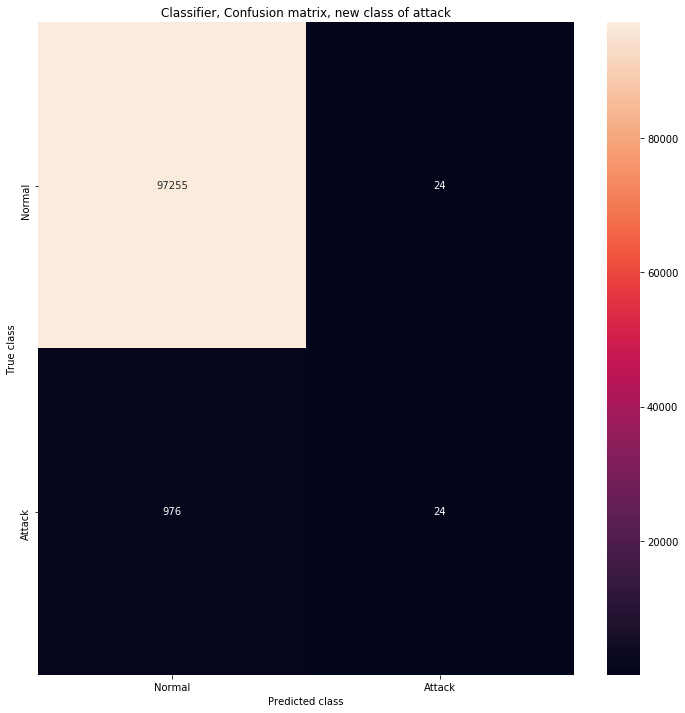

In [32]:
y_pred = [1 if e > class_threshold else 0 for e in new_class_prob_df.probabilities.values]
conf_matrix = confusion_matrix(new_class_prob_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Classifier, Confusion matrix, new class of attack")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa.

In [33]:
print("Cohen's Kappa = ", cohen_kappa_score(new_class_prob_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(new_class_prob_df.true_class, y_pred))


Cohen's Kappa =  0.044911315789739725
Accuracy =  0.9898248862931043


Reconstruct the test dataset using `fittedAutoencoder`, calculate the mean squared error of the reconstruction.  

In [34]:
aePredictions = fittedAutoencoder.predict(kddCupTest[featuresList])
mse = skm.mean_squared_error(kddCupTest[featuresList].transpose(),
                             aePredictions.transpose(),
                             multioutput='raw_values')
new_ae_error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': kddCupTest['Class']})

Construct ROC curve and calculate AUC for the autoencoder

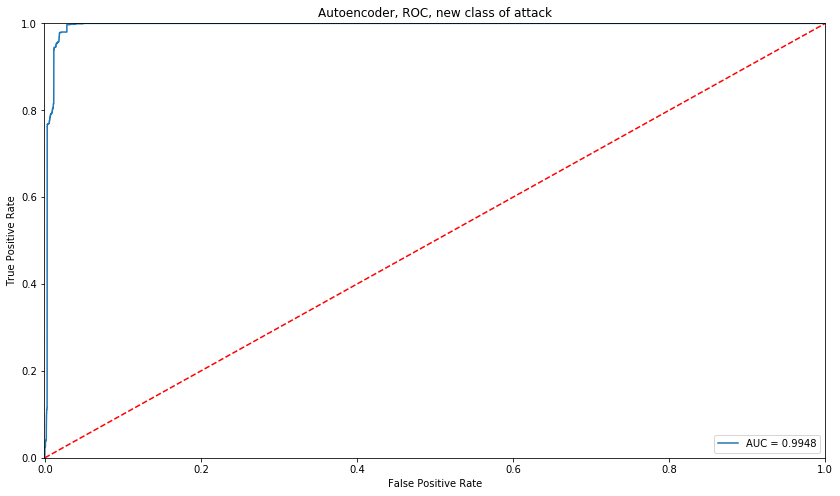

In [35]:
fpr, tpr, thresholds = roc_curve(new_ae_error_df.true_class, new_ae_error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Autoencoder, ROC, new class of attack')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Plot reconstruction error for different classes.  

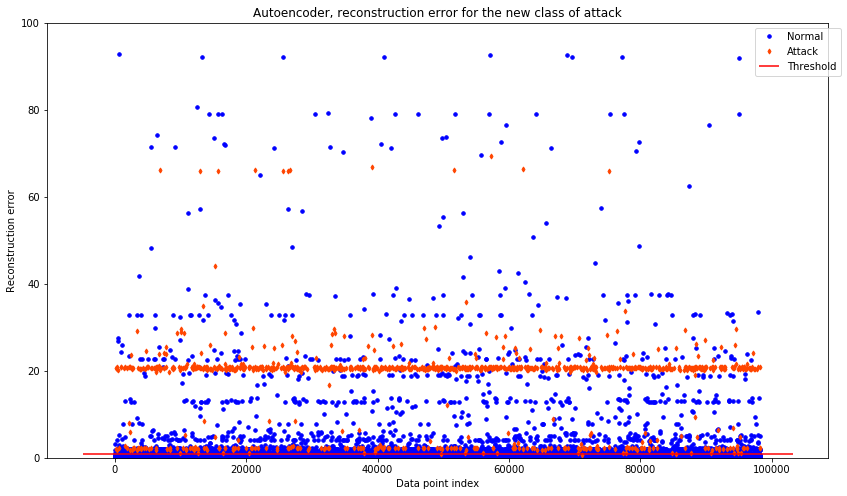

In [36]:
groups = new_ae_error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    if name == 1:
        MarkerSize = 3.5
        Color = 'orangered'
        Label = 'Attack'
        Marker = 'd'
    else:
        MarkerSize = 3.5
        Color = 'b'
        Label = 'Normal'
        Marker = 'o'
    ax.plot(group.index, group.reconstruction_error, 
            linestyle='',
            color=Color,
            label=Label,
            ms=MarkerSize,
            marker=Marker)
ax.hlines(ae_threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend(bbox_to_anchor=(0.9, 1))
plt.title("Autoencoder, reconstruction error for the new class of attack")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.ylim(0, 100)
plt.show();

Plot the confusion matrix for the threshold selected for the training dataset.  

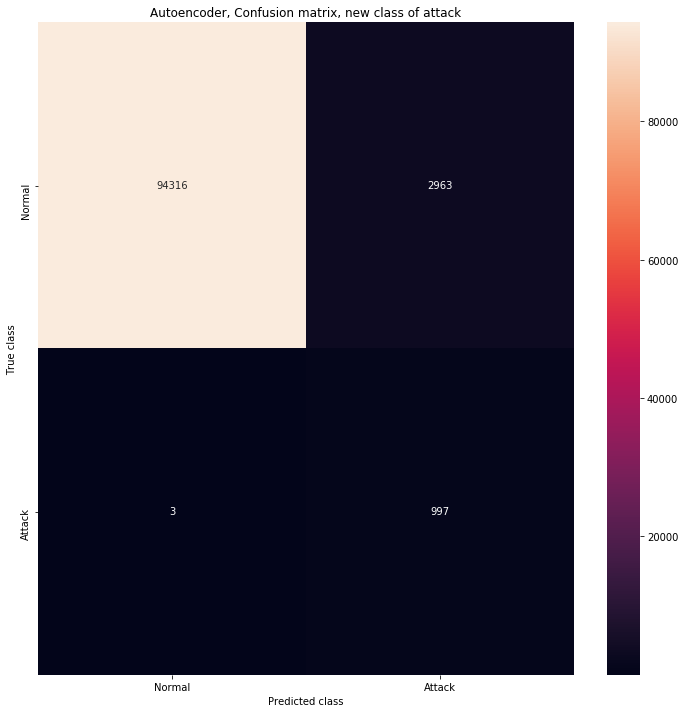

In [37]:
y_pred = [1 if e > ae_threshold else 0 for e in new_ae_error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(new_ae_error_df.true_class, y_pred)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Autoencoder, Confusion matrix, new class of attack")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Calculate Accuracy and Cohen's Kappa.

In [38]:
print("Cohen's Kappa = ", cohen_kappa_score(new_ae_error_df.true_class, y_pred))
print("Accuracy = ", accuracy_score(new_ae_error_df.true_class, y_pred))

Cohen's Kappa =  0.3921400095557478
Accuracy =  0.9698206127453475


The quality of the Classifier is worse on another type of attack. 